In [2]:
import requests
import pytz
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.lines import Line2D
from cycler import cycler
import seaborn as sns
from datetime import datetime, timedelta
import warnings
from urllib3.exceptions import InsecureRequestWarning
from matplotlib.colors import LinearSegmentedColormap

import glob
import os
import re

In [20]:
# Suppress only the InsecureRequestWarning
warnings.simplefilter("ignore", InsecureRequestWarning)
url = "https://publicationtool.jao.eu/core/api/data/initialComputation"
base_params = {
    "Filter": '{"Tso":["10XSI-ELES-----1"]}',
    "Skip": 0,
    "Take": 100
}

all_data = []

start_time = datetime(2025, 2, 2, 23, 0, 0)
end_time = datetime(2025, 2, 3, 23, 0, 0)
# end_time = datetime(2025, 1, 29, 0, 0, 0)

current_time = start_time
while current_time < end_time:
    from_utc = current_time.strftime("%Y-%m-%dT%H:%M:%S.000Z")
    to_utc = (current_time + timedelta(hours=1)).strftime("%Y-%m-%dT%H:%M:%S.000Z")
    
    params = base_params.copy()
    params["FromUtc"] = from_utc
    params["ToUtc"] = to_utc

    try:
        response = requests.get(url, params=params, verify=False)
        response.raise_for_status()
        data = response.json()
        if 'data' in data:
            all_data.extend(data['data'])
        else:
            print(f"No 'data' key found in response for {from_utc} to {to_utc}.")
    except requests.exceptions.RequestException as e:
        print(f"An error occurred for {from_utc} to {to_utc}: {e}")

    current_time += timedelta(hours=1)

if all_data:
    df = pd.DataFrame(all_data)
else:
    print("No data was retrieved.")

df['dateTimeUtc'] = pd.to_datetime(df['dateTimeUtc'], utc=True)
df['dateTimeUtc'] = df['dateTimeUtc'].dt.tz_convert(pytz.timezone('Europe/Ljubljana'))
df['dateTimeUtc'] = df['dateTimeUtc'].dt.tz_localize(None)
df.rename(columns={'dateTimeUtc': 'dateTimeEtc'}, inplace=True)
df = df.drop(['id','tso', 'cneEic','hubFrom','hubTo','substationFrom','substationTo',
               'contingencies','elementType','fmaxType','cneStatus', 'presolved','imax','u','contTso','ltaMargin', 'iva', 'cva','ftotalLtn'], axis=1)
df = df.iloc[:, :-14]

df['direction'] = df['direction'].apply(lambda x: f"({x})")
# CONTINGENCY preimenovanje
df['contName'] = df['contName'].astype(str)
df['contName'] = df['contName'].apply(lambda x: ' '.join(x.split()[4:]) if len(x.split()) > 6 else x)
df['contName'] = df['contName'].replace('None', 'BASECASE')
df['contName'] = df['contName'].replace('kV Cirkovce - Zerjavinec', '400 kV Cirkovce - Zerjavinec')
df['contName'] = df['contName'].replace('Divaca - Pehlin', '220 kV Divača - Pehlin')
df['contName'] = df['contName'].replace('Bericevo-Divaca', '400 kV Bericevo - Divača')
df['contName'] = df['contName'].replace('kV Divaca - Melina', '400 kV Divača - Melina')
df['contName'] = df['contName'].replace('Zerjavinec - Podlog Podlog - Zerjavinec', '220 kV Podlog - Žerjavinec')
df['contName'] = df['contName'].replace('Cirkovce - Heviz Cirkovce - Heviz', '400 kV Cirkovce - Heviz')
# CNEC preimenovanje
df['cneName'] = df['cneName'].replace('Cirkovce - Heviz ', '400 kV Cirkovce - Heviz ')
df['cneName'] = df['cneName'].replace('Podlog - Zerjavinec ','220 kV Podlog - Žerjavinec ')
df['cneName'] = df['cneName'].replace('220kV Divaca - Pehlin ','220 kV Divača - Pehlin ')
df['cneName'] = df['cneName'].replace('400 kV Krsko - Tumbri 1 ','400 kV Krško - Tumbri 1 ')
df['cneName'] = df['cneName'].replace('400 kV Krsko - Tumbri 2 ','400 kV Krško - Tumbri 2 ')
df['cneName'] = df['cneName'].replace('400 kV Krsko - Tumbri 2 ','400 kV Krško - Tumbri 2 ')
df['cneName'] = df['cneName'].replace('400 kV Cirkovce - Zerjavinec ', '400 kV Cirkovce - Žerjavinec ')
df['cneName'] = df['cneName'].replace('400 kV Divaca - Melina ', '400 kV Divača - Melina ')


In [21]:
df['contName'].unique()
# df[(df['contName'] == 'BASECASE') & (df['cneName'] == '400 kV Maribor - Kainachtal 1 ')]

array(['BASECASE', '400 kV Maribor - Kainachtal 2',
       '220 kV Obersielach - Podlog', '400 kV Maribor - Kainachtal 1',
       '400 kV Maribor - Cirkovce 1', '400 kV Maribor - Cirkovce 2',
       '400 kV Cirkovce - Zerjavinec', '400 kV Krsko - Tumbri 2',
       '220 kV Podlog - Žerjavinec', '400 kV Krsko - Tumbri 1',
       '220 kV Divača - Pehlin', '400 kV Cirkovce - Heviz',
       '400 kV Cirkovce - Krsko', '400 kV Divača - Melina',
       '400 kV Cirkovce - Podlog', '400 kV Bericevo - Krsko 1',
       '400 kV Bericevo - Krsko 2'], dtype=object)

# LF po elementih (BASECASE)

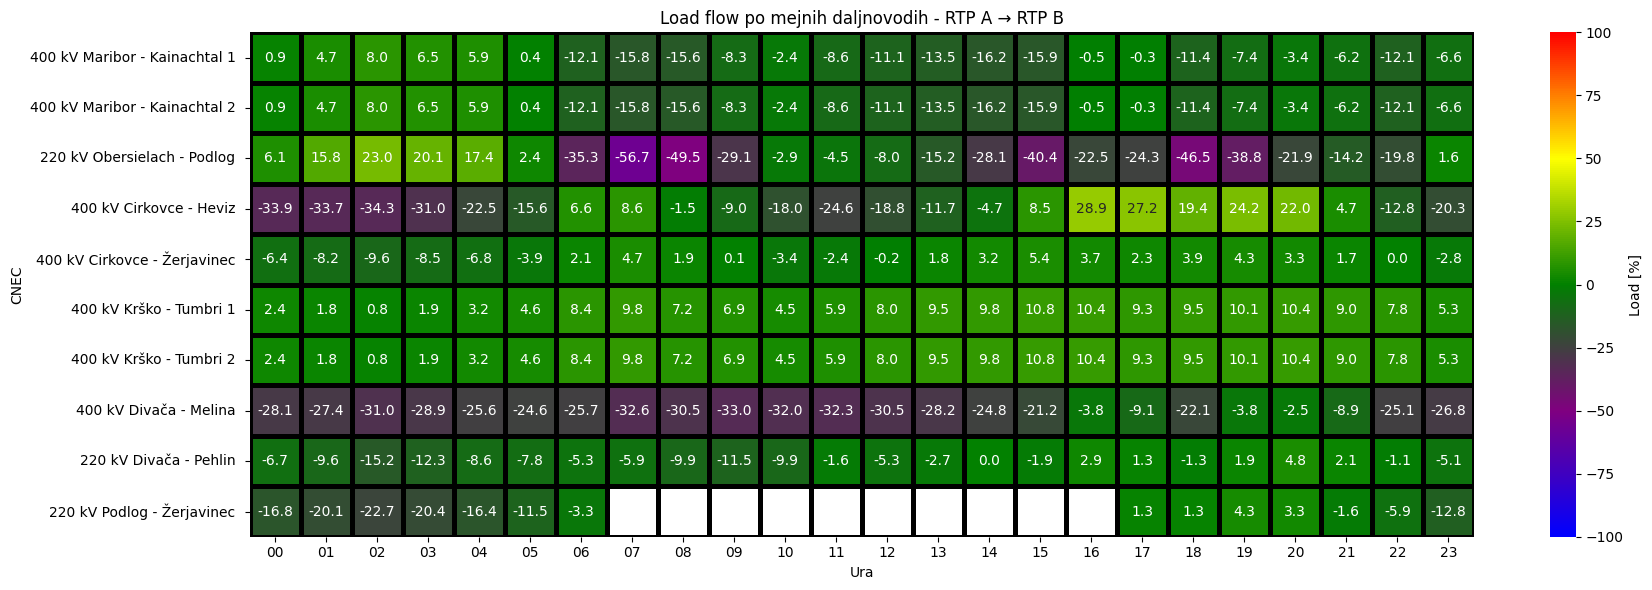

In [22]:
df_base = df[df['contName'] == 'BASECASE'].copy()
df_base = df_base[df_base['direction'] == '(DIRECT)']
df_base['load'] = (df_base['frefInit']/df_base['fmax'])*100

cne_name_order = ['400 kV Maribor - Kainachtal 1 ', '400 kV Maribor - Kainachtal 2 ',
       '220 kV Obersielach - Podlog ', '400 kV Cirkovce - Heviz ', '400 kV Cirkovce - Žerjavinec ',
       '400 kV Krško - Tumbri 1 ', '400 kV Krško - Tumbri 2 ','400 kV Divača - Melina ',
       '220 kV Divača - Pehlin ', '220 kV Podlog - Žerjavinec ']  # Your custom order

df_base['cneName'] = pd.Categorical(df_base['cneName'], categories=cne_name_order, ordered=False)
df_base['Hour_Minute'] = df_base['dateTimeEtc'].dt.strftime('%H')

heatmap_data = df_base.pivot_table(
    index='cneName',
    columns='Hour_Minute',
    values='load',  # The data to be visualized (can be counts or another metric)
    aggfunc='max',  # Use 'sum', 'mean', etc., depending on your needs
    observed=False
)

custom_cmap = LinearSegmentedColormap.from_list('CustomMap', ['Blue', 'Purple', 'green', 'yellow', 'Red'])

# Plot the heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(heatmap_data, cmap=custom_cmap, annot=True, fmt=".1f",
            linewidths=2.5, linecolor='black', vmin = -100, vmax = 100, cbar_kws={'label': 'Load [%]'})
plt.title("Load flow po mejnih daljnovodih - RTP A → RTP B")
plt.xlabel("Ura")
plt.ylabel("CNEC")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Dvig AMR po elementih (BASECASE)

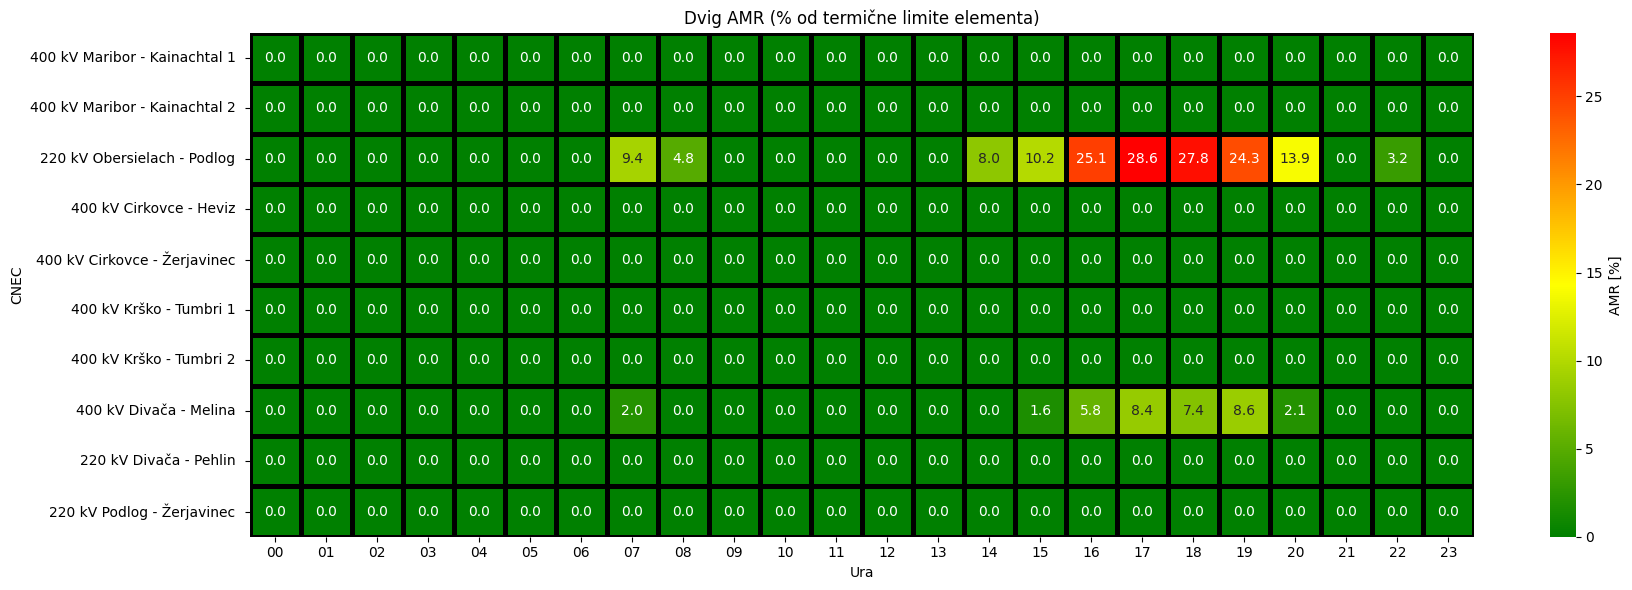

In [213]:
df_amr = df[df['contName'] == 'BASECASE'].copy()
df_amr = df_amr[df_amr['direction'] == '(OPPOSITE)']
df_amr['Hour_Minute'] = df_amr['dateTimeEtc'].dt.strftime('%H')
df_amr['cneName'] = pd.Categorical(df_amr['cneName'], categories=cne_name_order, ordered=False)
df_amr['amr'] = (df_amr['amr']/df_amr['fmax'])*100

heatmap_data = df_amr.pivot_table(
    index='cneName',
    columns='Hour_Minute',
    values='amr',  # The data to be visualized (can be counts or another metric)
    aggfunc='max',  # Use 'sum', 'mean', etc., depending on your needs
    observed=False
)

custom_cmap = LinearSegmentedColormap.from_list('CustomMap', ['green', 'yellow', 'Red'])

# Plot the heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(heatmap_data, cmap=custom_cmap, annot=True, fmt=".1f",
            linewidths=2.5, linecolor='black', cbar_kws={'label': 'AMR [%]'})
plt.title("Dvig AMR (% od termične limite elementa)")
plt.xlabel("Ura")
plt.ylabel("CNEC")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# N-1 KRŠITEV

In [214]:
df_cont = df[df['contName'] != 'BASECASE'].copy()
df_cont = df_cont[df_cont['direction'] == '(OPPOSITE)']
df_cont['abs_frefInit'] = df_cont['frefInit'].abs()

# Find the row where abs_frefInit is max within each group
idx = df_cont.groupby(['dateTimeEtc', 'cneName'])['abs_frefInit'].idxmax()

# Select the rows based on idxmax() results
df_cont = df_cont.loc[idx, ['dateTimeEtc', 'cneName', 'abs_frefInit', 'fmax', 'contName', 'amr']].reset_index(drop=True)
df_cont['info'] = df_cont['cneName'] + '\n' + '(N-1) ' + df_cont['contName']


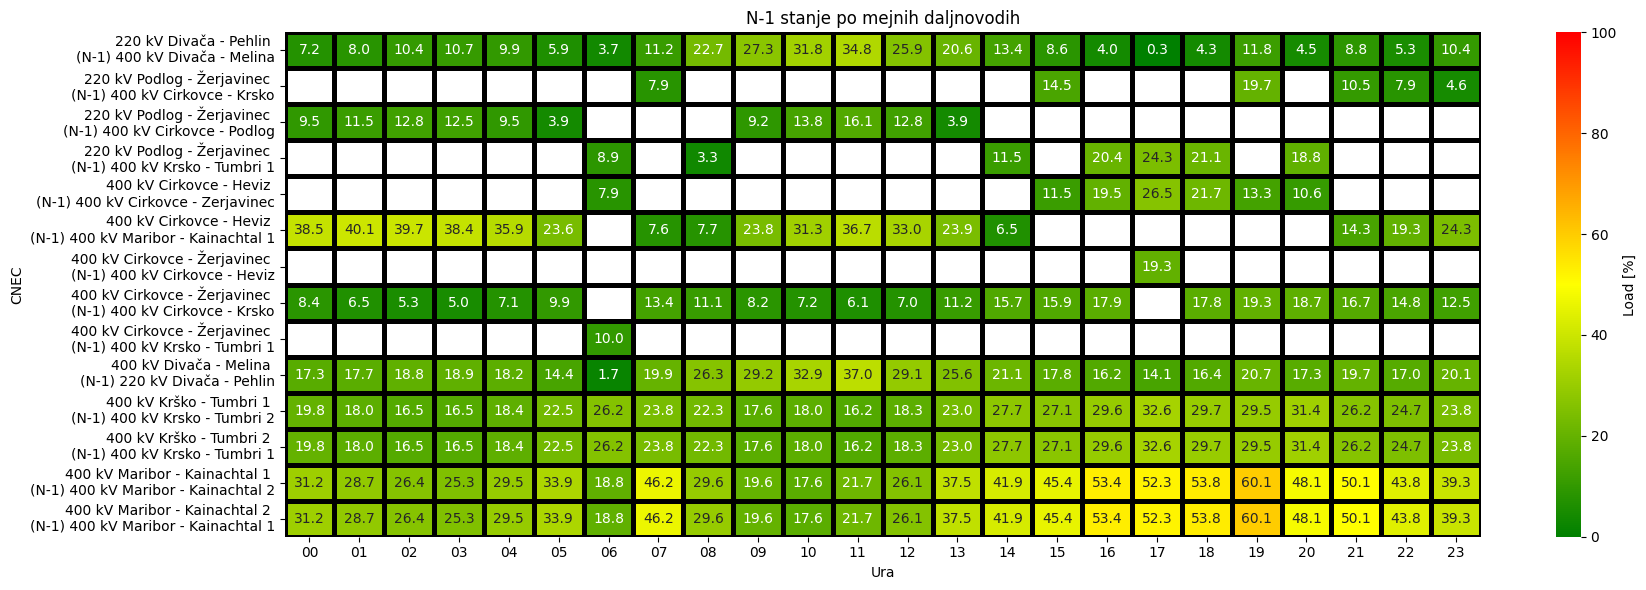

In [215]:
df_cont['Hour_Minute'] = df_cont['dateTimeEtc'].dt.strftime('%H')
df_cont['load'] = (df_cont['abs_frefInit']/df_cont['fmax'])*100

heatmap_data_cont = df_cont.pivot_table(
    index='info',
    columns='Hour_Minute',
    values='load',  # The data to be visualized (can be counts or another metric)
    aggfunc='max',  # Use 'sum', 'mean', etc., depending on your needs
    observed=False
)

custom_cmap = LinearSegmentedColormap.from_list('CustomMap', ['green', 'yellow', 'Red'])

# Plot the heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(heatmap_data_cont, cmap=custom_cmap, annot=True, fmt=".1f",
            linewidths=2.5, linecolor='black', vmin = 0, vmax = 100, cbar_kws={'label': 'Load [%]'})
plt.title("N-1 stanje po mejnih daljnovodih")
plt.xlabel("Ura")
plt.ylabel("CNEC")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Dvig AMR po elementih (N-1)

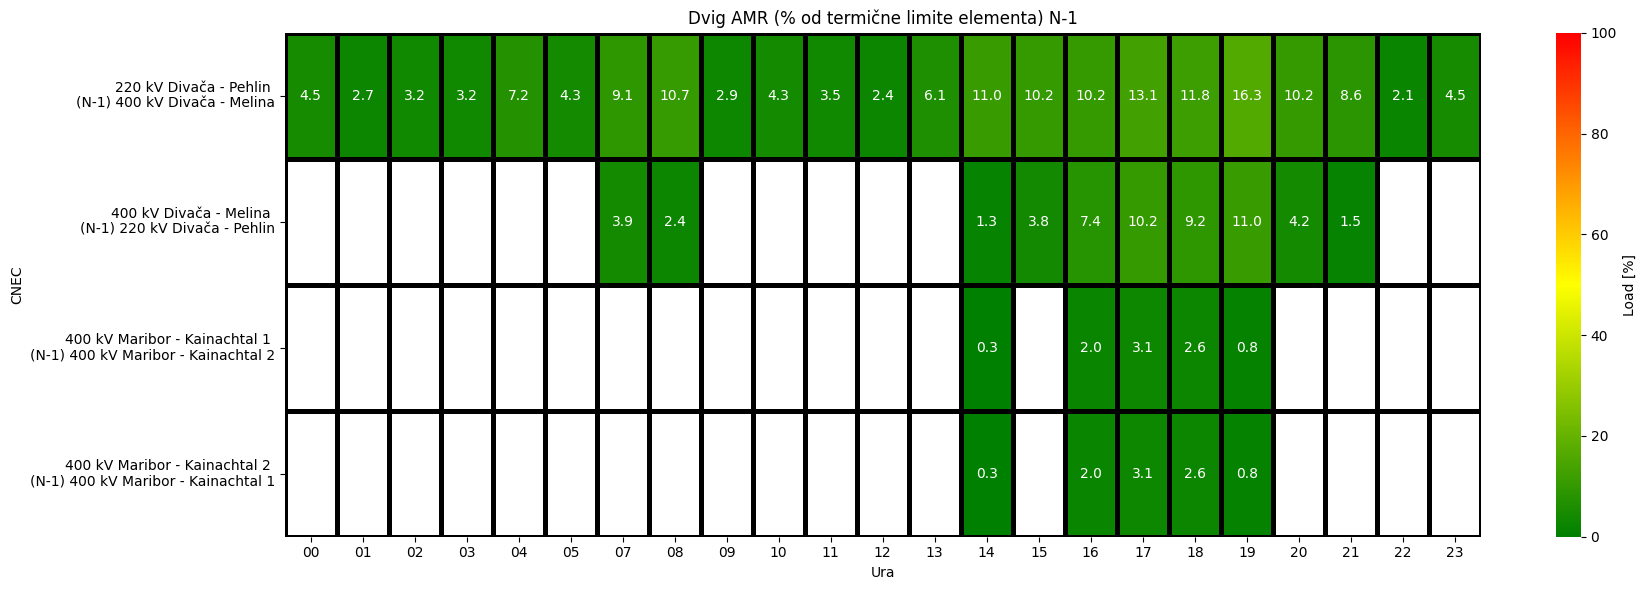

In [216]:
df_cont_amr = df_cont[df_cont['amr']>0].copy()
df_cont_amr['amr'] = (df_cont_amr['amr']/df_cont_amr['fmax'])*100

heatmap_data_cont = df_cont_amr.pivot_table(
    index='info',
    columns='Hour_Minute',
    values='amr',  # The data to be visualized (can be counts or another metric)
    aggfunc='max',  # Use 'sum', 'mean', etc., depending on your needs
    observed=False
)

custom_cmap = LinearSegmentedColormap.from_list('CustomMap', ['green', 'yellow', 'Red'])

# Plot the heatmap
plt.figure(figsize=(18, 6))
sns.heatmap(heatmap_data_cont, cmap=custom_cmap, annot=True, fmt=".1f",
            linewidths=2.5, linecolor='black', vmin = 0, vmax = 100, cbar_kws={'label': 'Load [%]'})
plt.title("Dvig AMR (% od termične limite elementa) N-1")
plt.xlabel("Ura")
plt.ylabel("CNEC")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# PRIMERJAVA PERUN - JAO

In [188]:

# Direktorij do PERUN datotek
directory = r'C:\Users\rjaka\Desktop\Kapacitete - ELES\PERUN REPORT\2025_29_01'

# Use glob to find all Excel files starting with "R1_"
file_paths = glob.glob(os.path.join(directory, 'R1_*.xlsx'))  # Adjust extension if needed

# Initialize an empty list to store DataFrames
dfs = []

# Loop through each file
for file in file_paths:
    # Extract the filename without the directory path
    filename = os.path.basename(file)
    
    # Extract the 'TS' part using split (assuming the format remains consistent)
    ts_value = filename.split('_')[2] + '_' + filename.split('_')[3]  # Extracting "TS1_0000"
    ts_value = re.sub(r'TS(\d)_', r'TS0\1_', ts_value)
    # Read the Excel file
    perun = pd.read_excel(file)
    
    # Add the 'TS' column
    perun['TS'] = ts_value
    
    # Append to list
    dfs.append(perun)

# Optionally, concatenate them into a single DataFrame
perun_df = pd.concat(dfs, ignore_index=True)

perun_df = perun_df[(perun_df['Outage']=='BaseCase')&(perun_df['CNEC']==True) & (perun_df['Direction']=='DIRECT')&(perun_df['Monitored Branch']=='[SI-HR] 220kV Podlog - Zerjavinec [DIR] [SI]')]
perun_df = perun_df.sort_values(by=['TS','Monitored Branch'])
columns = ['TS'] + [col for col in perun_df.columns if col != 'TS']
perun_df = perun_df[columns]

In [189]:

# Primerjava JAO/PERUN
df_base_test = df_base[df_base['cneName']=='220 kV Podlog - Žerjavinec '] # Filtriranje JAO df
df_base_test = df_base_test[['dateTimeEtc','cneName', 'frefInit']]
df_base_test['Monitored Branch - PERUN'] = perun_df['Monitored Branch'].values
df_base_test['Fref_init - PERUN'] = perun_df['Fref_init'].values.round(1)
df_base_test['TS - PERUN'] = perun_df['TS'].values
df_base_test['delta_Fref_init'] = abs(df_base_test['frefInit'] - df_base_test['Fref_init - PERUN'])
df_base_test.head(5)

,dateTimeEtc,cneName,frefInit,Monitored Branch - PERUN,Fref_init - PERUN,TS - PERUN,delta_Fref_init
41,2025-01-29 00:00:00,220 kV Podlog - Žerjavinec,3.0,[SI-HR] 220kV Podlog - Zerjavinec [DIR] [SI],12.2,TS01_0000,9.2
111,2025-01-29 01:00:00,220 kV Podlog - Žerjavinec,-2.0,[SI-HR] 220kV Podlog - Zerjavinec [DIR] [SI],7.1,TS02_0100,9.1
181,2025-01-29 02:00:00,220 kV Podlog - Žerjavinec,-1.0,[SI-HR] 220kV Podlog - Zerjavinec [DIR] [SI],7.6,TS03_0200,8.6
251,2025-01-29 03:00:00,220 kV Podlog - Žerjavinec,0.0,[SI-HR] 220kV Podlog - Zerjavinec [DIR] [SI],6.3,TS04_0300,6.3
321,2025-01-29 04:00:00,220 kV Podlog - Žerjavinec,0.0,[SI-HR] 220kV Podlog - Zerjavinec [DIR] [SI],7.1,TS05_0400,7.1


In [92]:
perun_df.to_excel(r'C:\Users\rjaka\Desktop\ PERUN_all_drata.xlsx', index=False)# Izvoz datotek

In [90]:
# # Create a new DataFrame with only the filtered columns
df_slo = df.copy()
# Dictionary to map country codes to country names
country_mapping = {
    'AT': 'Avstrija',
    'BE': 'Belgija',
    'CZ': 'Češka',
    'DE': 'Nemčija',
    'FR': 'Francija',
    'HR': 'Hrvaška',
    'HU': 'Madžarska',
    'NL': 'Nizozemska',
    'PL': 'Poljska',
    'RO': 'Romunija',
    'SI': 'Slovenija',
    'SK': 'Slovaška',
    'IT': 'Italija'
}

# Function to map country code to full name
def map_country_name(col_name):
    # Extract the country code (last two characters)
    country_code = col_name.split('_')[1]
    # Map the country code to the full country name
    country_name = country_mapping.get(country_code, country_code)  # Default to country code if not found
    return f"{country_name}"

# Change column names by applying the mapping
df_slo.columns = [map_country_name(col) if 'coreNp_' in col else col for col in df_slo.columns]
# df_slo = df_slo.round(0).astype(int)
df_slo

,dateTimeEtc,cneName,direction,contName,ram,fmax,frm,frefInit,fnrao,fref,fcore,fall,fuaf,amr,load,Hour_Minute
0,2025-01-29 00:00:00,400 kV Maribor - Kainachtal 1,(DIRECT),BASECASE,1474.0,1330.0,133.0,-277.0,0.0,-277.0,-161.0,-101.0,-61.0,0.0,-20.827068,00
3,2025-01-29 00:00:00,400 kV Maribor - Kainachtal 2,(DIRECT),BASECASE,1474.0,1330.0,133.0,-277.0,0.0,-277.0,-161.0,-101.0,-61.0,0.0,-20.827068,00
6,2025-01-29 00:00:00,220 kV Obersielach - Podlog,(DIRECT),BASECASE,453.0,374.0,37.0,-116.0,0.0,-116.0,-195.0,-147.0,-49.0,0.0,-31.016043,00
14,2025-01-29 00:00:00,400 kV Cirkovce - Heviz,(DIRECT),BASECASE,1338.0,1109.0,111.0,-341.0,0.0,-341.0,-127.0,-165.0,38.0,0.0,-30.748422,00
26,2025-01-29 00:00:00,400 kV Krško - Tumbri 1,(DIRECT),BASECASE,1025.0,1330.0,133.0,172.0,0.0,172.0,113.0,89.0,23.0,0.0,12.932331,00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1639,2025-01-29 23:00:00,400 kV Krško - Tumbri 2,(DIRECT),BASECASE,978.0,1330.0,133.0,219.0,0.0,219.0,112.0,94.0,18.0,0.0,16.466165,23
1642,2025-01-29 23:00:00,400 kV Divača - Melina,(DIRECT),BASECASE,1422.0,1330.0,133.0,-225.0,0.0,-225.0,-633.0,-275.0,-357.0,0.0,-16.917293,23
1644,2025-01-29 23:00:00,400 kV Cirkovce - Žerjavinec,(DIRECT),BASECASE,889.0,1109.0,111.0,108.0,0.0,108.0,13.0,-13.0,26.0,0.0,9.738503,23
1649,2025-01-29 23:00:00,220 kV Divača - Pehlin,(DIRECT),BASECASE,322.0,374.0,37.0,15.0,0.0,15.0,-75.0,-61.0,-14.0,0.0,4.010695,23
